<a href="https://colab.research.google.com/github/moodlep/vae_playground/blob/main/colab_notebooks/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get fashion MNIST from PyTorch

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



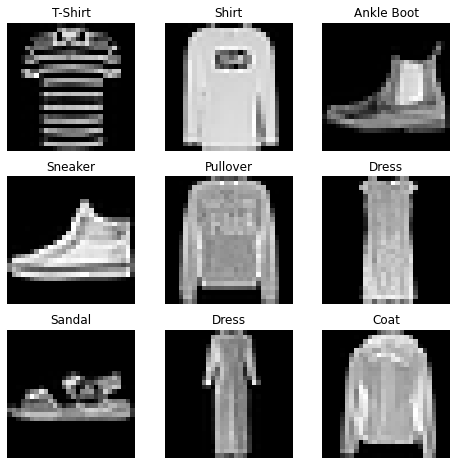

In [2]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [62]:
training_data[0][0].shape, training_data.data.shape

(torch.Size([1, 28, 28]), torch.Size([60000, 28, 28]))

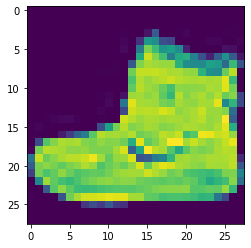

In [63]:
plt.imshow(training_data.data[0])
plt.show()

In [88]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

NameError: ignored

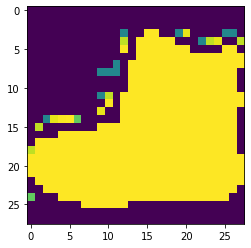

In [8]:
img = training_data.data[0]
img.float().sigmoid()
plt.imshow(training_data.data[0].float().sigmoid())
plt.show()

# AE code: 

Implement basic barebones autoencoder https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

$$
\mathbf{x}^{\prime}=f_{\theta}\left(g_{\phi}(\mathbf{x})\right)
$$

$$
L_{\mathrm{AE}}(\theta, \phi)=\frac{1}{n} \sum_{i=1}^{n}\left(\mathbf{x}^{(i)}-f_{\theta}\left(g_{\phi}\left(\mathbf{x}^{(i)}\right)\right)\right)^{2}
$$

In [1]:
import torch.nn as nn

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self, dims, activation_fnc = nn.ReLU()):

    super(Autoencoder, self).__init__()
    # dims = [input_dim, hidden_dim, encoded_dim]

    # Encoder g(x) -> x_hat
    self.encoder = nn.Sequential(
        nn.Linear(dims[0], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[2])
    )

    self.decoder = nn.Sequential(
        nn.Linear(dims[2], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[0])
    )

  def forward(self, input):
    x_hat = self.encoder(input)
    x = self.decoder(x_hat)

    return x

In [ ]:
def eval():
  # Lazy eval: let's see how the first test image progresses
  with torch.no_grad():
    output = ae(test_data.data[0].view(-1).unsqueeze(0).float())
    plt.imshow(output.reshape(28,28))
    plt.show()  

In [ ]:
config = {
    'epochs': 10,
    'eval_progression': False, # call eval during training
    'eval_steps': 100,
    'eval_epoch': True  # call eval after each epoch
}

In [ ]:
bs = 64 # batch size
ae = Autoencoder([784, 256, 4])

optimiser = torch.optim.Adam(ae.parameters(), lr=2.5e-4)
losses = []
for epoch in range(config['epochs']):

  # Sample batches in loop
  for i, batch in enumerate(iter(train_dataloader)):
    images = batch[0].view(batch[0].shape[0], -1)

    # forward pass
    predictions = ae(images)

    loss = ((images-predictions)**2).sum(-1).mean()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # print(epoch, loss.item())
    losses.append(loss.item())

    if config['eval_progression']:
      if i % config['eval_steps'] == 0:
        eval()

  if config['eval_epoch']:
    eval()


In [ ]:
test_data.data[0].shape, test_data.data[0].view(-1).unsqueeze(0).shape

(torch.Size([28, 28]), torch.Size([1, 784]))

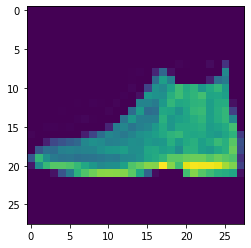

In [ ]:
plt.imshow(test_data.data[0])
plt.show()

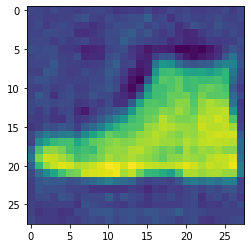

In [ ]:
eval()

## latent layer

In [ ]:
ae.encoder(test_data.data[0])

# Alternative code using conv nets

(Src: https://ai.plainenglish.io/denoising-autoencoder-in-pytorch-on-mnist-dataset-a76b8824e57e)

Tried the code from this blog to see how much better a conv net performs and also to try the denoising aspect. 

Found bug in loss function... MSE (decoded output, noise_input)


As per lillog blog, the loss is between the decoded output and the original (not noisy) input! 

$$
\tilde{\mathbf{X}}^{(i)} \sim \mathcal{M}_{\mathcal{D}}\left(\tilde{\mathbf{x}}^{(i)} \mid \mathbf{x}^{(i)}\right)
$$

$$
L_{\mathrm{DAE}}(\theta, \phi)=\frac{1}{n} \sum_{i=1}^{n}\left(\mathbf{x}^{(i)}-f_{\theta}\left(g_{\phi}\left(\tilde{\mathbf{x}}^{(i)}\right)\right)\right)^{2}
$$

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)


In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

## With noise

In [ ]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    

        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)

        loss = loss_fn(decoded_data, image_batch)  # corrected loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    return torch.sum(torch.tensor(train_loss)).mean()


## Without noise

In [ ]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader: 
        encoded_data = encoder(image_batch.to(device))
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    return torch.sum(torch.tensor(train_loss)).mean()

## Train

In [ ]:
### Training cycle
noise_factor = 0.3
num_epochs = 10
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    # ### Validation  (use the testing function)
    # val_loss = test_epoch_den(
    #     encoder=encoder, 
    #     decoder=decoder, 
    #     device=device, 
    #     dataloader=valid_loader, 
    #     loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    # history_da['train_loss'].append(train_loss)
    # history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,0))
    # plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

EPOCH 1/10

 EPOCH 1/10 	 train loss 17.404 	 val loss 0.000
EPOCH 2/10

 EPOCH 2/10 	 train loss 17.330 	 val loss 0.000
EPOCH 3/10

 EPOCH 3/10 	 train loss 17.273 	 val loss 0.000
EPOCH 4/10

 EPOCH 4/10 	 train loss 17.222 	 val loss 0.000
EPOCH 5/10

 EPOCH 5/10 	 train loss 17.176 	 val loss 0.000
EPOCH 6/10

 EPOCH 6/10 	 train loss 17.137 	 val loss 0.000
EPOCH 7/10

 EPOCH 7/10 	 train loss 17.099 	 val loss 0.000
EPOCH 8/10

 EPOCH 8/10 	 train loss 17.063 	 val loss 0.000
EPOCH 9/10

 EPOCH 9/10 	 train loss 17.030 	 val loss 0.000
EPOCH 10/10

 EPOCH 10/10 	 train loss 16.998 	 val loss 0.000


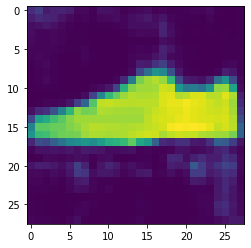

In [ ]:
# no noise version 
with torch.no_grad():  
  img = test_data[i][0].unsqueeze(0)
  output = decoder(encoder(img))

  plt.imshow(output.squeeze().numpy())
  plt.show()  

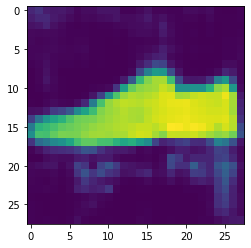

In [ ]:
# noisy with corrected loss function
with torch.no_grad():  
  img = test_data[i][0].unsqueeze(0)
  output = decoder(encoder(img))

  plt.imshow(output.squeeze().numpy())
  plt.show()  

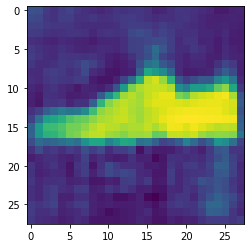

In [ ]:
# noisy with original loss function
with torch.no_grad(): 
  img = test_data[i][0].unsqueeze(0)
  output = decoder(encoder(img))

  plt.imshow(output.squeeze().numpy())
  plt.show()  

# VAE

$$
L_{\mathrm{VAE}}(\theta, \phi)=-\log p_{\theta}(\mathbf{x})+D_{\mathrm{KL}}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p_{\theta}(\mathbf{z} \mid \mathbf{x})\right)
$$
$$
=-\mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z} \mid \mathbf{x})} \log p_{\theta}(\mathbf{x} \mid \mathbf{z})+D_{\mathrm{KL}}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p_{\theta}(\mathbf{z})\right)
$$

p - decoder
q - encoder
z - latent

In [9]:
import torch
import torch.nn as nn
import torch.distributions as distributions

In [20]:
class VAE(nn.Module):

  def __init__(self, dims, activation_fnc = nn.ReLU()):

    super(VAE, self).__init__()
    # dims = [input_dim, hidden_dim, encoded_dim]
    self.dims = dims

    # Encoder g(x) -> z_mu, z_std
    self.encoder = nn.Sequential(
        nn.Linear(dims[0], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[2]) # network head splits here for mean and std for z 
    )

    self.decoder = nn.Sequential(
        nn.Linear(dims[2], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[1]),
        activation_fnc,
        nn.Linear(dims[1], dims[0]),
        # nn.Sigmoid()
    )

  def forward(self, input):
    means = self.encoder(input)  
    stds = self.encoder(input)

    # convert stds to cov_mat: 
    a = torch.eye(self.dims[2]).unsqueeze(0).expand((input.shape[0],self.dims[2],self.dims[2]))
    b = stds.unsqueeze(-1).expand_as(a)
    cov_mat = b*a

    encoder_dist = torch.distributions.MultivariateNormal(means, cov_mat.abs())
    z = encoder_dist.sample()
    print("shape of z ", z.shape)

    # decoder distribution is a Bernoulli that will gen 784 1's and 0's
    decoder_output = self.decoder(z)
    decoder_dist = torch.distributions.Bernoulli(logits = decoder_output)
    # x_hat = decoder_dist.sample().reshape(-1,28,28)

    # convert the inputs to 1's and 0's for the Bernoulli
    transformed_input = torch.zeros_like(input)
    torch.maximum(input, torch.zeros_like(input), out = transformed_input)

    recon_loss = decoder_dist.log_prob(transformed_input.bool())

    # KL Loss: 
    # Normal prior dist
    prior = torch.distributions.MultivariateNormal(torch.zeros_like(means), torch.eye(self.dims[2]).unsqueeze(0).expand((input.shape[0],self.dims[2],self.dims[2])))
    kl_loss = distributions.kl_divergence(encoder_dist, prior)

    return recon_loss, kl_loss

In [53]:
28*28

784

## Quick Test of Multivariate normal

In [7]:
m = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
m.sample()

tensor([0.1029, 0.3221])

In [21]:
batch_size = 10
z_dims = 5

# Generate a batch of means and stds
means = torch.randn((10,5))
stds = torch.randn((10,5))
means, stds

(tensor([[-0.9037,  0.7639,  0.8674,  0.4277,  0.0614],
         [-0.5178, -0.5380,  0.6384, -0.2140,  0.2417],
         [-0.6731,  2.4680, -0.5663,  0.2197,  2.4935],
         [-1.4279, -1.2434, -1.1396,  1.2729, -1.7595],
         [-0.1917, -0.4983,  1.3450,  0.2562, -1.0695],
         [ 1.0890,  3.2572,  1.1290,  0.7529, -2.2703],
         [-0.5428, -0.3522,  0.7309, -2.6492,  0.6497],
         [-1.3211, -0.3574,  0.1064, -1.6073,  0.9784],
         [ 0.4691, -1.4178,  0.3760, -2.7406, -1.1650],
         [-0.2949,  1.2758,  0.2219,  0.1453, -0.3440]]),
 tensor([[-0.0703,  1.3324,  0.1667, -0.1345,  0.4825],
         [-1.0565, -1.2195, -0.5221,  1.3575, -0.7810],
         [-1.2138, -0.3774,  0.9295, -1.3361,  0.6219],
         [ 1.1528,  1.6248, -0.8355, -0.2293,  0.5784],
         [-0.3850, -0.1346,  0.7041, -0.1657, -0.6971],
         [-0.1377,  1.1324, -1.6671, -0.9383,  1.5566],
         [-2.2511,  0.8499,  0.5088,  2.7578, -1.0534],
         [-0.6930,  0.3100, -0.4274, -0.2898, 

In [51]:
a = torch.eye(5).unsqueeze(0).expand((10,5,5))
b = stds.unsqueeze(-1).expand_as(a)
cov_mat = b*a
cov_mat.shape

torch.Size([10, 5, 5])

In [52]:
m = distributions.MultivariateNormal(means, cov_mat.abs())
m.sample()

tensor([[-0.8814,  1.7798,  1.2383,  0.5742,  1.3484],
        [-0.1265, -2.3588,  0.5563, -1.8039,  1.2125],
        [ 0.0844,  2.5043, -1.0463,  0.1986,  3.6948],
        [-1.0231,  0.9243, -1.0509,  0.9579, -1.4947],
        [ 0.3585, -0.4100,  1.4560,  0.0885, -1.8726],
        [ 0.3916,  2.5412,  1.2092,  0.7095, -1.2538],
        [-1.6470,  0.2660,  1.4310, -2.1332,  0.1371],
        [-1.5892, -0.0459, -0.6302, -1.3209,  0.6398],
        [-0.2174, -1.2773, -0.8166, -2.0783, -0.7382],
        [ 0.2645,  1.4677,  0.9534,  1.8103, -0.8951]])

### Matrix scratchings!!

In [50]:
a = torch.eye(5).unsqueeze(0).expand((10,5,5))
a.shape

torch.Size([10, 5, 5])

In [34]:
a = a.expand((10,5,5))
a

tensor([[[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0

In [48]:
b = stds.unsqueeze(-1).expand_as(a)

In [49]:
b*a

tensor([[[-0.0703, -0.0000, -0.0000, -0.0000, -0.0000],
         [ 0.0000,  1.3324,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.1667,  0.0000,  0.0000],
         [-0.0000, -0.0000, -0.0000, -0.1345, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.4825]],

        [[-1.0565, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -1.2195, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.5221, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.3575,  0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.7810]],

        [[-1.2138, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.3774, -0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.0000,  0.9295,  0.0000,  0.0000],
         [-0.0000, -0.0000, -0.0000, -1.3361, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.6219]],

        [[ 1.1528,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.6248,  0.0000,  0.0000,  0.0000],
         [-0.0000, -0.0000, -0.8355, -0.00

# Training

In [ ]:
def eval():
  # Lazy eval: let's see how the first test image progresses
  with torch.no_grad():
    output = ae(test_data.data[0].view(-1).unsqueeze(0).float())
    plt.imshow(output.reshape(28,28))
    plt.show()  

In [12]:
config = {
    'epochs': 10,
    'eval_progression': False, # call eval during training
    'eval_steps': 100,
    'eval_epoch': True  # call eval after each epoch
}

In [21]:
bs = 64 # batch size
vae = VAE([784, 256, 4])

optimiser = torch.optim.Adam(vae.parameters(), lr=2.5e-4)
losses = []
for epoch in range(config['epochs']):

  # Sample batches in loop
  for i, batch in enumerate(iter(train_dataloader)):
    images = batch[0].view(batch[0].shape[0], -1)

    # forward pass
    recon_loss, kl_loss = vae(images)

    loss = -recon_loss + kl_loss

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # print(epoch, loss.item())
    losses.append(loss.item())

    if config['eval_progression']:
      if i % config['eval_steps'] == 0:
        eval()

  if config['eval_epoch']:
    eval()


shape of z  torch.Size([64, 4])


RuntimeError: ignored

In [14]:
%debug

> /usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py(289)_validate_sample()
    287         if not valid.all():
    288             raise ValueError(
--> 289                 "Expected value argument "
    290                 f"({type(value).__name__} of shape {tuple(value.shape)}) "
    291                 f"to be within the support ({repr(support)}) "

ipdb> up
> /usr/local/lib/python3.7/dist-packages/torch/distributions/bernoulli.py(93)log_prob()
     91     def log_prob(self, value):
     92         if self._validate_args:
---> 93             self._validate_sample(value)
     94         logits, value = broadcast_all(self.logits, value)
     95         return -binary_cross_entropy_with_logits(logits, value, reduction='none')

ipdb> up
> <ipython-input-11-bc0fdcf6c8e6>(44)forward()
     42     decoder_dist = torch.distributions.Bernoulli(logits = decoder_output)
     43     # x_hat = decoder_dist.sample().reshape(-1,28,28)
---> 44     recon_loss = decoder_dist.


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



In [17]:
s = torch.tensor([-0.1, 0.0, 3.0])
t = torch.zeros_like(s)
torch.maximum(s, torch.zeros_like(s), out = t)
t

tensor([0., 0., 3.])

In [83]:
distributions.Bernoulli(logits=torch.randn(5)).log_prob(torch.zeros(5))

tensor([-0.8114, -0.9609, -1.0940, -1.3499, -1.0643])

In [ ]:
image

In [ ]:
test_data.data[0].shape, test_data.data[0].view(-1).unsqueeze(0).shape

(torch.Size([28, 28]), torch.Size([1, 784]))

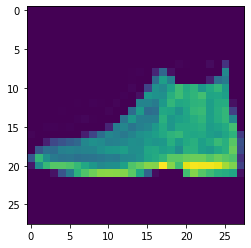

In [ ]:
plt.imshow(test_data.data[0])
plt.show()

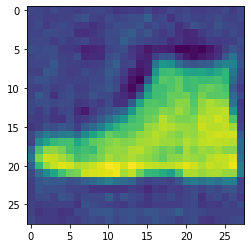

In [ ]:
eval()